# NLP classification - supervised learning

In this example, you will learn how you can use supervised learning algorithms for NLP classification. We will use documents from mtsamples again. The task is to classify a document into its clinical specialty, e.g. pediatrics or hematology.

We will use classification algorithms as implemented in sci-kit learn, and evaluate with cross-validation before testing on unseen test data.

We will experiment with different ways of representing the documents for the classifiers.

material in parts from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

Written by Sumithra Velupillai, March 2019 - updated February 2020; February 2025

# 1: Packages
We will use a number of different packages for this exercise

In [77]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
try:
    import xlrd
except ImportError as e:
    !pip install xlrd
    import xlrd

import numpy as np

import warnings; warnings.simplefilter('ignore')


In [78]:
# We'll use scikit-learn for the classification algorithms.
# https://scikit-learn.org/stable/

#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [79]:
## sklearn also has some nice funtions for representations

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## and for evaluation
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score



In [80]:
## Since we're working with text, we might need to tokenize for some of these representations.
# We'll use nltk here, but there are other nlp packages available for this
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords







[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
# You have also learnt about embedding representations. These can also be used for classification.
# We will use a library called Zeugma, which allows using pre-trained embedding models
#Zeugma library: https://github.com/nkthiebaut/zeugma

try:
    from zeugma.embeddings import EmbeddingTransformer
except ImportError as e:
    !pip install zeugma
    !pip install theano
    from zeugma.embeddings import EmbeddingTransformer

from datetime import datetime
print(datetime.now())


2025-03-19 03:30:40.064155


# 2: Corpus
Read in the training data.

In [82]:

xlds_training = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/classification/classification_trainingdata.xlsx?raw=true'
trainingdata = pd.read_excel(xlds_training)



Take a look at the content of the training data. What are we trying to classify? What are the labels we want to try to learn? How many instances do we have?

In [83]:
trainingdata['label'].value_counts()

,count
label,
hematology,81
pediatrics,63
pain,56
psychiatrypsychology,48


What types of features do you think would be useful for the classification task? Where can we get them? Take a look at one or two of the documents. Can you guess which classification label these belong to?

In [84]:
trainingtxt_example = trainingdata['txt'].tolist()[0]
print(trainingtxt_example)

_x000D_
        _x000D_
        _x000D_
_x000D_
        _x000D_
        
REASON FOR CONSULTATION:
  Thrombocytopenia.


HISTORY OF PRESENT ILLNESS:
  Mrs. XXX is a 17-year-old lady who is going to be 18 in about 3 weeks.  She has been referred for the further evaluation of her thrombocytopenia.  This thrombocytopenia was detected on a routine blood test performed on the 10th of June 2006.  Her hemoglobin was 13.3 with white count of 11.8 at that time.  Her lymphocyte count was 6.7.  The patient, subsequently, had a CBC repeated on the 10th at Hospital where her hemoglobin was 12.4 with a platelet count of 26,000.  She had a repeat of her CBC again on the 12th of June 2006 with hemoglobin of 14, white count of 11.6 with an increase in the number of lymphocytes.  Platelet count was 38.  Her rapid strep screen was negative but the infectious mononucleosis screen is positive.  The patient had a normal platelet count prior too and she is being evaluated for this low platelet count.

The pat

In [85]:
trainingtxt_example = trainingdata['txt'].tolist()[231]
print(trainingtxt_example)

_x000D_
        _x000D_
        _x000D_
_x000D_
        _x000D_
        
CHIEF COMPLAINT:
  Head injury.


HISTORY: 
 This 16-year-old female presents to Children's Hospital via paramedic ambulance with a complaint at approximately 6 p.m. while she was at band practice using her flag device.  She struck herself in the head with the flag.  There was no loss of consciousness.  She did feel dizzy.  She complained of a headache.  She was able to walk.  She continued to participate in her flag practice.  She got dizzier.  She sat down for a while and walked and during the second period of walking, she had some episodes of diplopia, felt that she might faint and was assisted to the ground and was transported via paramedic ambulance to Children's Hospital for further evaluation.


PAST MEDICAL HISTORY: 
 Hypertension.


ALLERGIES:
  DENIED TO ME; HOWEVER, IT IS NOTED BEFORE SEVERAL ACCORDING TO MEDITECH.


CURRENT MEDICATIONS: 
 Enalapril.


PAST SURGICAL HISTORY: 
 She had some kind of an ab

# 3: Representation - BoW

The most common baseline feature representation for text classification tasks is to use the *bag-of-words* representation, in a document-term matrix. Let's build a simple one using raw counts and only keeping a maximum of 500 features. We can use the CountVectorizer function from sklearn, and tokenize using a function from nltk.

In [86]:
first_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
first_vectorizer.fit(trainingdata['txt'].tolist())
first_fit_transformed_data = first_vectorizer.fit_transform(trainingdata['txt'])


We can now look at this transformed representation for an example document.

In [87]:
first_transformed_data = first_vectorizer.transform([trainingdata['txt'].tolist()[231]])
print (first_transformed_data)

  (0, 3)	3
  (0, 7)	29
  (0, 9)	55
  (0, 14)	1
  (0, 17)	1
  (0, 24)	1
  (0, 25)	22
  (0, 26)	1
  (0, 28)	7
  (0, 29)	8
  (0, 32)	2
  (0, 33)	2
  (0, 34)	1
  (0, 35)	1
  (0, 47)	2
  (0, 48)	1
  (0, 49)	1
  (0, 53)	2
  (0, 54)	15
  (0, 57)	1
  (0, 61)	1
  (0, 62)	1
  (0, 63)	5
  (0, 66)	1
  (0, 70)	5
  :	:
  (0, 414)	1
  (0, 424)	1
  (0, 426)	1
  (0, 427)	1
  (0, 429)	2
  (0, 433)	1
  (0, 436)	1
  (0, 437)	11
  (0, 441)	4
  (0, 443)	1
  (0, 444)	2
  (0, 453)	15
  (0, 464)	1
  (0, 468)	1
  (0, 472)	1
  (0, 474)	6
  (0, 476)	1
  (0, 478)	1
  (0, 484)	1
  (0, 485)	2
  (0, 487)	1
  (0, 490)	9
  (0, 491)	1
  (0, 492)	4
  (0, 495)	1


What word is represented by the different indices? Have a look at a few examples.

In [88]:
print (first_vectorizer.get_feature_names_out()[32])

abdomen


In [89]:
print(first_fit_transformed_data.shape)
print ('Amount of Non-Zero occurences: ', first_fit_transformed_data.nnz)

(248, 500)
Amount of Non-Zero occurences:  30502


# 4: Classification
Let's build a classifier with this feature representation. In text classification, many classification algorithms have been shown to work well. Sci-kit learn has implementations for many different types of classification algorithms - have a look at their website!

Let's try a K nearest neighbour classifier.


In [90]:
kneighbour_classifier = KNeighborsClassifier().fit(first_fit_transformed_data, trainingdata['label'])

We now have a trained model. But how do we know how well it works? Let's evaluate it on the test data.

In [91]:

xlds_test = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/classification/classification_test_data.xlsx?raw=true'
testdata = pd.read_excel(xlds_test)



## We need to transform this data to the same representation
first_fit_transformed_testdata = first_vectorizer.transform(testdata['txt'])

In [92]:
first_fit_transformed_testdata
kneighbour_predicted = kneighbour_classifier.predict(first_fit_transformed_testdata)
kneighbour_predicted

array(['pediatrics', 'pain', 'pain', 'pain', 'pediatrics', 'hematology',
       'pediatrics', 'hematology', 'pediatrics', 'pain', 'hematology',
       'pediatrics', 'hematology', 'psychiatrypsychology', 'pain',
       'hematology', 'hematology', 'pain', 'pain', 'hematology',
       'pediatrics', 'pain', 'hematology', 'psychiatrypsychology',
       'pediatrics', 'hematology', 'hematology'], dtype=object)

Let's make a list of all the labels in our dataset to evaluate, and then run some standard evaluation metrics

In [93]:
labels = list(set(testdata['label']))
print(metrics.classification_report(testdata['label'], kneighbour_predicted, target_names=labels))



                      precision    recall  f1-score   support

          hematology       0.60      0.67      0.63         9
          pediatrics       0.75      1.00      0.86         6
                pain       0.71      0.71      0.71         7
psychiatrypsychology       1.00      0.40      0.57         5

            accuracy                           0.70        27
           macro avg       0.77      0.70      0.69        27
        weighted avg       0.74      0.70      0.69        27



What do you think about these results? There are probably ways of improving this, by changing the representation or maybe trying a different classifier model.
__There is one main problem though: we can't use this test data to try different configurations! Why?__

# 5: N-fold cross-validation

We can employ n-fold cross-validation on the training data to experiment with different representations, parameters, and classifiers.

There are also various metrics that can be used to evaluate classification results.


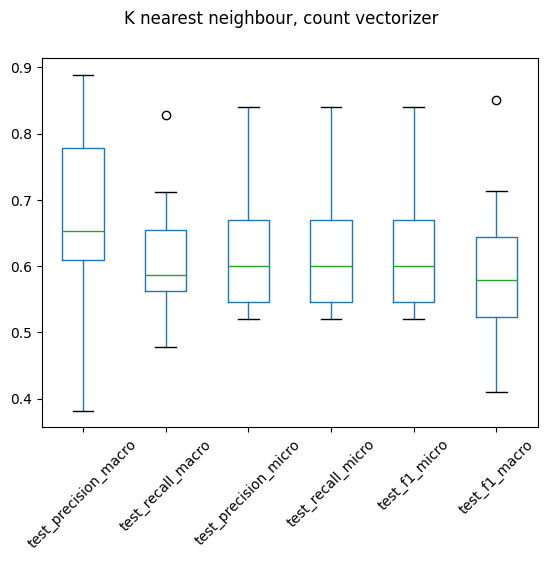

In [94]:
kneighbour_classifier = KNeighborsClassifier().fit(first_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(kneighbour_classifier, first_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('K nearest neighbour, count vectorizer')
plt.show()

What happens if we try another classifier? Let's try a random forest classifier.

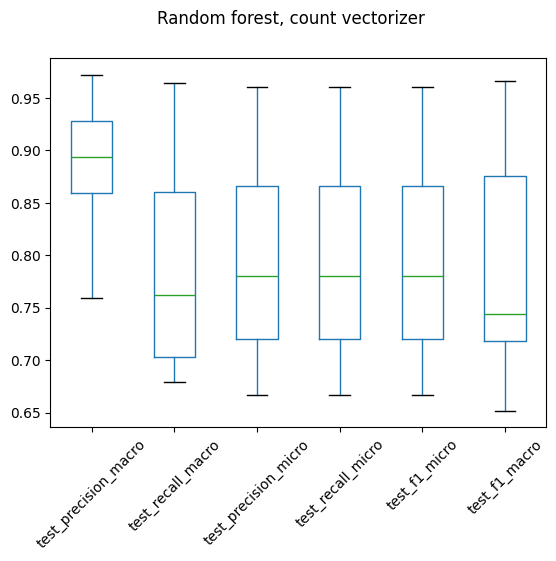

In [95]:
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(first_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(rf_classifier, first_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('Random forest, count vectorizer')
plt.show()

Was this better or worse? Are there any parameters worth changing?

# 6: Another representation model: Tf-idf
We have used a very simple bag-of-words representation. What happens if we try something else? Let's try tf-idf. This is considered a strong baseline in many text classification tasks.

In [96]:

stopWords = list(stopwords.words('english'))
tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['txt'])
second_fit_transformed_data =  tfidf_vect.transform(trainingdata['txt'])
second_fit_transformed_data

<248x10455 sparse matrix of type '<class 'numpy.float64'>'
	with 55597 stored elements in Compressed Sparse Row format>

What other parameters can you change in this representation? How does this look different from the CountVectorizer representation?

Let's now use this with the KNN classifier.

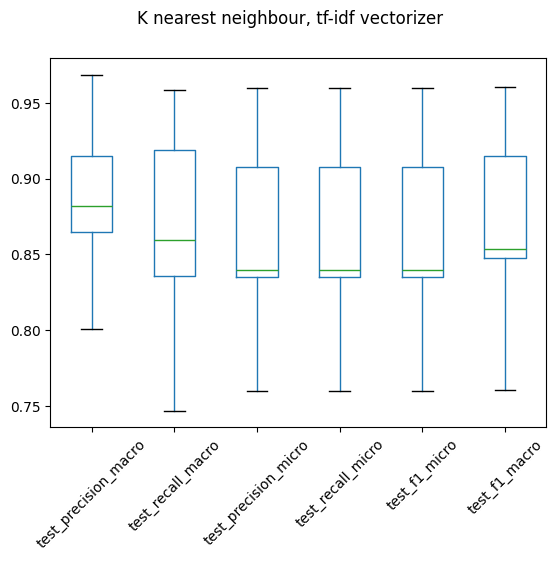

In [97]:
kneighbour_classifier = KNeighborsClassifier().fit(second_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(kneighbour_classifier, second_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('K nearest neighbour, tf-idf vectorizer')
plt.show()

This looks better, doesn't it? Why do you think this works better?

# 7: Representations: embeddings

Last week, you learnt about embedding representations. What might be the benefit of using this type of representation instead of counts or tf-idf?

As you saw, there are many pre-trained embedding models available online. Let's try using one of these on this data.

Zeugma is a package where you can use embeddings in sklearn.
https://github.com/nkthiebaut/zeugma

It allows you to directly download pre-trained models that have been released from the gensim website.


Let's use a basic glove model.

In [98]:
glove = EmbeddingTransformer('glove')


We now need to transform our training data to map to this embedding model.

In [99]:
glove_transformed_training_data = glove.transform(trainingdata['txt'])

Have a look at what the data now looks like with this representation

In [100]:
glove_transformed_training_data

array([[-0.06901653,  0.23141852, -0.0103017 , ..., -0.00840962,
        -0.1129333 , -0.2936374 ],
       [-0.1314008 ,  0.22093552,  0.01704605, ...,  0.00743521,
        -0.09343443, -0.3224292 ],
       [-0.21260077,  0.22974722,  0.05217805, ..., -0.03708735,
        -0.02639649, -0.3227366 ],
       ...,
       [-0.17562525,  0.27378783,  0.04055113, ...,  0.10207053,
        -0.01623572, -0.32465863],
       [-0.34308803,  0.1576001 , -0.03746452, ...,  0.1564335 ,
        -0.14194974, -0.35664514],
       [-0.22268341,  0.14659327,  0.0234719 , ...,  0.02757135,
        -0.11957677, -0.35197183]], dtype=float32)

Let's build a classifier with this representation and evaluate with 10-fold cross-validation.

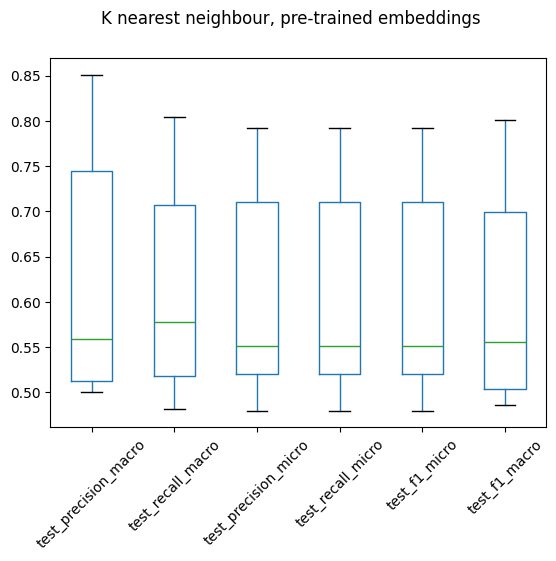

In [101]:
kneighbour_classifier = KNeighborsClassifier().fit(glove_transformed_training_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(kneighbour_classifier, glove_transformed_training_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('K nearest neighbour, pre-trained embeddings')
plt.show()

What do you think about these results? What is happening here?

There are a number of pre-trained embedding models that have been released openly, a full list of pretrained embeddings to experiment with using this library: https://github.com/RaRe-Technologies/gensim-data#models

You can play with these if you want, e.g.:
glove = EmbeddingTransformer('glove-wiki-gigaword-50')

# 8: Classifiers, representations, evaluation

You've now seen that you get very different results depending on which representation you use, which classifier, and also that there are many different metrics to analyse.

Let's try some different configurations all in one go. We'll create a dictionary with the three different types of representations, and a list of different classification algorithms, and apply all these configurations to see what seems to yield best results according to a chosen evaluation metric using 10-fold cross validation.

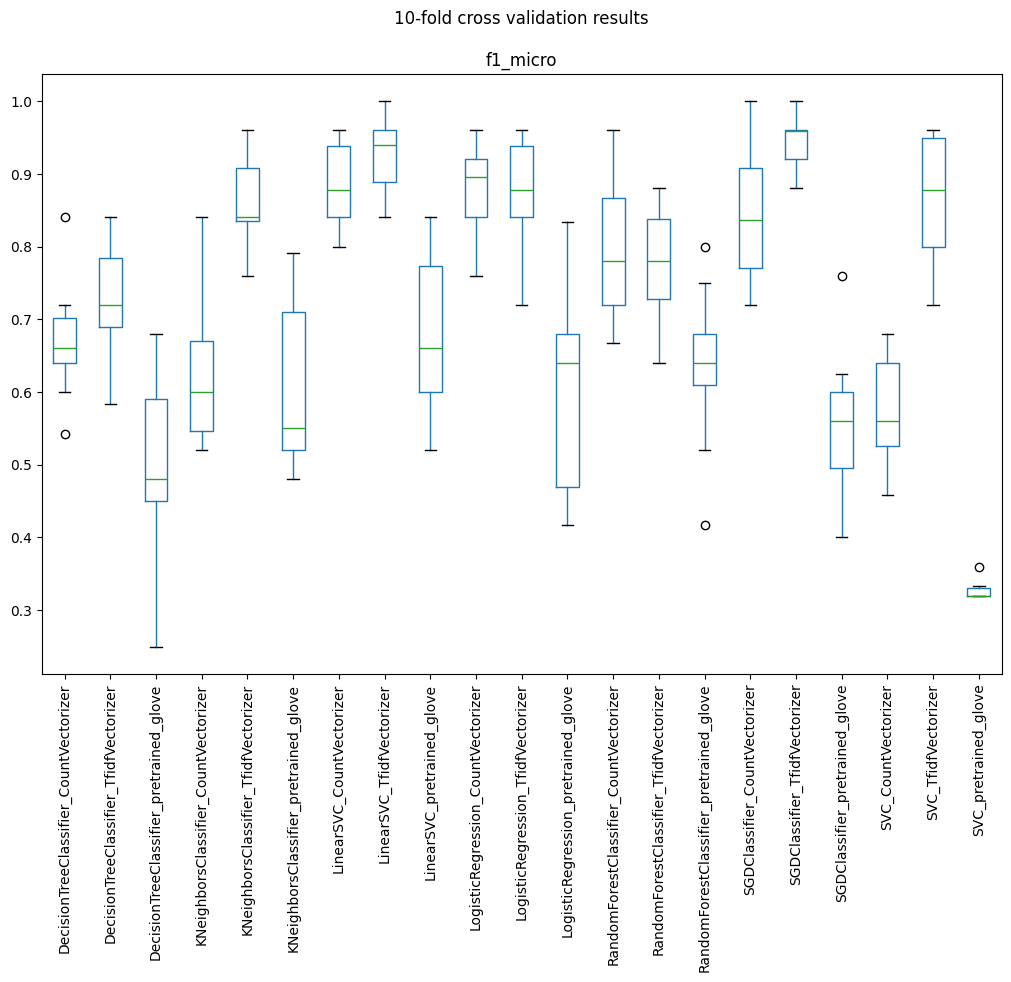

In [102]:

representations = {}

vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
xtrain_countvect = vectorizer.fit_transform(trainingdata['txt'])
representations['CountVectorizer'] = xtrain_countvect

tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['txt'])
xtrain_tfidf =  tfidf_vect.transform(trainingdata['txt'])
representations['TfidfVectorizer'] = xtrain_tfidf

x_train_glove = glove.transform(trainingdata['txt'])
representations['pretrained_glove'] = x_train_glove



CV = 10

classifier_models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        DecisionTreeClassifier(),
        SVC(),
        LinearSVC(multi_class='ovr', C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      penalty='l2', random_state=0, tol=1e-05, verbose=0),
        SGDClassifier(),
        LogisticRegression(random_state=0),
        KNeighborsClassifier(),
]

cv_df = pd.DataFrame(index=range(CV * (len(classifier_models)*len(representations))))
entries = []


for representation, transformed_vector in representations.items():
    score = 'f1_micro'
    for model in classifier_models:
      model_name = model.__class__.__name__+'_'+representation
      accuracies = cross_val_score(model, transformed_vector, trainingdata['label'], scoring=score, cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', score])
bp = cv_df.boxplot(by='model_name', column=[score], grid=False, rot=90, figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('10-fold cross validation results')
plt.show()

What conclusions do you draw from this? Which classifier and which representation would you choose as your final model? Why?

# Assignment 1: Your turn to build a classifier

Answer questions by placing your code in the code cell below, running it to provide output, and giving your written answers in this markdown cell

**1.1 Choose one classifier and one representation format and test it on the blind test data. What do you think about your results, and how do they relate to the 10-fold cross validation results above?**

---


###Answer:

I chose **LinearSVC** as the classifier and **TfidfVectorizer** as the representation format.

  Overall accuracy: 96%
  
###Category-wise F1-score:

① pediatrics and psychiatry/psychology achieved perfect scores (1.00 F1-score), indicating the model performs exceptionally well on these categories.

② hematology has a precision of 0.90, while its recall is 1.00, meaning that while it captures all hematology cases, some incorrect predictions were also made.

③ pain has a lower recall (0.86), indicating that some instances were misclassified.

###These results align well with the 10-fold cross-validation results from the boxplot:

①LinearSVC + TfidfVectorizer achieved the highest median F1-score with the smallest interquartile range (IQR), indicating it is a stable and high-performing model.

②The final test accuracy reflects the expected performance observed during cross-validation.


---


**1.2 What other configurations could you try before deciding on a final model?**

---
###Answer:

Before finalizing the model, I could experiment with the following configurations:

###Different text representation methods:

CountVectorizer: Uses raw term frequency instead of weighted TF-IDF values, which might be beneficial for certain datasets.

Pretrained word embeddings (pretrained_glove): These embeddings carry additional semantic meaning, which could improve generalization.
Different classifiers:

①LogisticRegression: Performed well in cross-validation but might be less robust than SVM.
②RandomForestClassifier: Could capture complex patterns but is prone to overfitting.
③KNeighborsClassifier: Computationally expensive but may perform well on structured text.

### Hyperparameter tuning:

Adjusting C in LinearSVC to control regularization strength.

Modifying the ngram_range parameter in TfidfVectorizer to incorporate bi-grams or tri-grams.

Changing max_features in vectorizers to refine word selection.



---


**1.3 Is it appropriate to experiment with this on the test data? Why or why not?**


---

###Answer

####No, it is not appropriate!

The test set should be used for final evaluation, not model tuning.

Experimenting on the test set may lead to data leakage, where the model "learns" from the test data, causing over-optimistic results.

If we continuously adjust hyperparameters based on test data performance, our model will not generalize well to unseen data.
####A better approach:

Use cross-validation (cv=10) to select the best model.

Split the available data into training, validation, and test sets:

i. The validation set should be used to tune hyperparameters.

ii.  The test set should only be used once for the final evaluation.


In [103]:
## PUT YOUR CODE ANSWERS IN HERE, AND RUN IT TO GIVE OUTPUT
## First step: Transform your training and test data to your chosen representation.

## choose a representation: CountVectorizer or TfidfVectorizer, or embeddings
chosen_representation = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)

## transform the training data
# something like this: transformed_training_data = chosen_representation.transform(trainingdata['txt'])
transformed_training_data = chosen_representation.fit_transform(trainingdata['txt'])
## transform the test data
# something like this: transformed_test_data = chosen_representation.transform(testdata['txt'])
transformed_test_data = chosen_representation.transform(testdata['txt'])
## Second step: Create a classifier - the one you think gave best results when experimenting with cross-validation
from sklearn.svm import LinearSVC
chosen_classifier = LinearSVC()
## train the classifier on the training data
# e.g. chosen_classifier.fit(transformed_training_data, trainingdata['label'])
chosen_classifier.fit(transformed_training_data, trainingdata['label'])
## predict labels on the test data
# e.g. predicted = chosen_classifier.predict(transformed_test_data)
predicted = chosen_classifier.predict(transformed_test_data)
## what results do you get?
# e.g. print(metrics.classification_report(testdata['label'], predicted, target_names=set(testdata['label'].tolist())))
print(metrics.classification_report(testdata['label'], predicted, target_names=set(testdata['label'].tolist())))

                      precision    recall  f1-score   support

          hematology       0.90      1.00      0.95         9
          pediatrics       1.00      1.00      1.00         6
                pain       1.00      0.86      0.92         7
psychiatrypsychology       1.00      1.00      1.00         5

            accuracy                           0.96        27
           macro avg       0.97      0.96      0.97        27
        weighted avg       0.97      0.96      0.96        27



# Assignment 2: use your classifier to predict labels on unseen text

Answer questions by placing your code in the three code cells below, running it to provide output, and giving your written answers in this markdown cell

**What happens if you try to predict a label with a completely new text using your chosen trained classifier model? Does it seem to classify correctly?**


---
###Answer:

①"Patient with severe depression." is predicted as psychiatrypsychology. This prediction seems reasonable because "depression" is a key term in psychiatry.

②"5-year old girl with asthma." is predicted as pediatrics. This prediction is correct because "5-year-old girl" and "asthma" strongly indicate a pediatric case.

③"Her pain is severe." is predicted as pain. This prediction is correct because "pain" is directly mentioned and is a key term in pain-related diagnoses.

Overall, the classifier performs well in these test cases, correctly classifying all three unseen texts based on key terms. However, it may still be vulnerable to ambiguous or complex cases where more contextual understanding is required.


---



In [104]:
new_text = 'Patient with severe depression.'
testX = chosen_representation.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)
## code will be something like this:
# testX = chosen_representation.transform([new_text])
# predicted = chosen_classifier.predict(testX)
# print(predicted)

['psychiatrypsychology']


In [105]:
new_text = '5-year old girl with asthma.'
testX = chosen_representation.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

['pediatrics']


In [106]:
new_text = 'Her pain is severe.'
testX = chosen_representation.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

['pain']


# Assignment 3: Evaluation

**Write ten example sentences or paragraphs where you assign the correct label to each of them. Then pass them to the classifier and calculate precision, recall and f-score, by completing the skeleton code in the cell below, and running it to give output. Analyse and discuss the results, giving your answer in this markdown cell.**

***Gold label values: psychiatrypsychology, hematology, pain, pediatrics***


---

###Answer:

The classifier achieved an accuracy of 0.80, with a macro-average F1-score of 0.82. Psychiatrypsychology showed the best performance with an F1-score of 1.00, while hematology had the lowest precision at 0.50, indicating frequent misclassification. Pain and pediatrics exhibited lower recall (0.67), suggesting that some instances were not correctly identified.

Misclassification may be attributed to semantic overlap among categories, insufficient training data, and limitations in text representation. Hematology’s low precision suggests a need for more balanced data distribution and refined feature extraction.

To enhance performance, incorporating domain-specific embeddings, optimizing hyperparameters, and expanding training data could improve classification accuracy and robustness. Further model refinements are necessary to achieve more reliable medical text classification.

---



In [107]:
new_text = [
    "The patient experiences sharp pain in the lower back after an injury.",
    "A toddler is diagnosed with pneumonia and requires hospitalization.",
    "A routine blood test shows abnormally low platelet levels.",
    "A teenager with bipolar disorder is struggling with mood swings.",
    "Persistent headaches and sensitivity to light affecting daily activities.",
    "A premature baby is receiving special care in the neonatal intensive unit.",
    "The patient has a genetic blood disorder causing excessive clotting.",
    "Therapy sessions are recommended for a patient with severe depression.",
    "Chronic joint inflammation making movement difficult.",
    "A child with a high fever and rash is being monitored for possible measles."
]

new_gold_labels = [
    "pain",
    "pediatrics",
    "hematology",
    "psychiatrypsychology",
    "pain",
    "pediatrics",
    "hematology",
    "psychiatrypsychology",
    "pain",
    "pediatrics"
]

testX = chosen_representation.transform(new_text)

predicted = chosen_classifier.predict(testX)
## compare the predicted labels with the gold labels. HINT: metrics.classification_report is useful here
print(predicted)

print(metrics.classification_report(new_gold_labels, predicted, target_names=set((new_gold_labels))))

['pain' 'hematology' 'hematology' 'psychiatrypsychology' 'hematology'
 'pediatrics' 'hematology' 'psychiatrypsychology' 'pain' 'pediatrics']
                      precision    recall  f1-score   support

          hematology       0.50      1.00      0.67         2
          pediatrics       1.00      0.67      0.80         3
                pain       1.00      0.67      0.80         3
psychiatrypsychology       1.00      1.00      1.00         2

            accuracy                           0.80        10
           macro avg       0.88      0.83      0.82        10
        weighted avg       0.90      0.80      0.81        10




You've now experimented with different respresentations for text classification, different classification algorithms, and experimental setups.

There are many other alternative approaches available today.


For instance, there are pre-trained biomedical embeddings, trained on scientific literature, one example: https://www.aclweb.org/anthology/W16-2922.pdf
https://github.com/cambridgeltl/BioNLP-2016

There are also many online resources with additional examples and ideas, here's one example: https://towardsdatascience.com/text-classification-in-python-dd95d264c802